# Численные методы
## Вариант 15, Дылкин Даниил 301гр

## Постановка задачи:
Рассматриваем задачу о вычислении однократного интеграла $ J(F) = \int_{a}^{b} F(x) \,dx \ $, где подынтегральная функция имеет вид: 
$$ F(x) = \frac{f(x)}{(x - a)^\alpha(b - x)^\beta}\\ $$
С заданной точностью $ \varepsilon $ с использованием двух типов формул.

Импортируем необходимые для работы библиотеки

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Задаем коэффиценты.

In [2]:
a = 1.1
b = 2.3
x = [a, b]
eps = 1e-06
alpha = 4/5
betta = 0
N = 10

Как видим, мы имеем особенность на левом конце. Сама функция выглядит так:
$$ f(x) = 3.5\cos(0.7x)\exp(-5x/3) + 2.4\sin(5.5x)\exp(-3x/4) + 5$$

В качестве весовой функции мы берем:
$$ p(x) =  \frac{1}{(x - a)^\alpha  (b - x)^\beta}\\ $$

In [3]:
def func(x):
    ans = 3.5 * np.cos(0.7*x) * np.exp(-5*x/3) + 2.4 * np.sin(5.5*x) * np.exp(-3*x/4) + 5
    return ans

def p(x):
    ans = 1 / ((x - a)**alpha * (b - x)**betta)
    return ans

def F(x):
    return p(x)*func(x)

Посмотрим, как выглядит $F(x)$

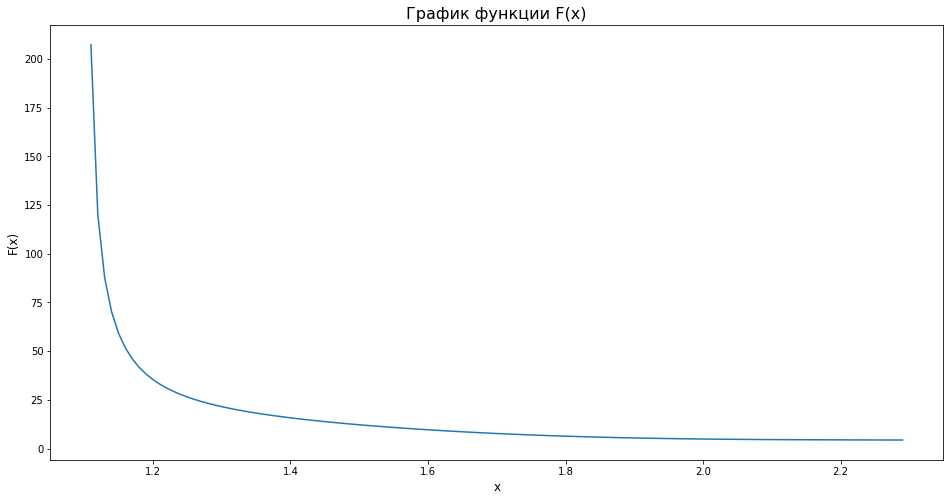

In [4]:
x = np.arange(a+0.01, b, 0.01)

plt.figure(figsize=(16, 8))

plt.title('График функции F(x)', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('F(x)', fontsize=12)

plt.plot(x, F(x))

Убрать, то что ниже

In [5]:
# посчиатем интеграл уже известным способом, чтобы был примерный ориентир.
from scipy.integrate import quad
I = quad(F, a, b)
I

(27.56649553432024, 2.259877263099952e-08)

## Правило средних прямоугольников

Для начала, воспользуемся составной формулой средних прямоугольников.  
Она выглядит так:
$$ J(F) = \int_{a}^{b} F(x) \,dx \ \approx h\sum_{i=1}^{n} F(a + (i - 0.5)h)$$

In [6]:
def quad_srpr(f, a, b, n): # правило средних прямоугольников
    h = (b - a) / n # шаг
    xs = np.linspace(b, a, n+1)[:-1] + h/2 # не включает в себя [:-1], чтобы не брать конец промежутка
    fs = f(xs) # находим значения функции в точках
    return np.sum(fs * h) # суммируем

In [7]:
quad_srpr(F, a, b, 1)

3.6908921602391285

In [8]:
sq = []
for i in range(1, 30000):
    sq.append(quad_srpr(F, a, b, i))

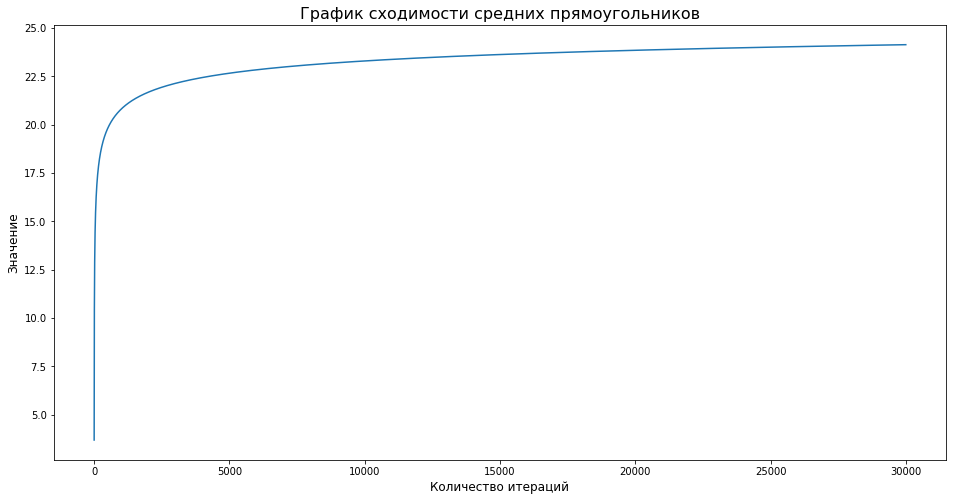

In [9]:
x = np.arange(1, 30000, 1)

plt.figure(figsize=(16, 8))

plt.title('График сходимости средних прямоугольников', fontsize=16)
plt.xlabel('Количество итераций', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.plot(x, sq)

Как мы видим, при достаточно большом количестве итераций, наш ответ не стабилизируется, и продолжает расти. Это происходит потому что наша функция, как мы видели ранее, устремляется в бесконечность на левом конце.  


## Алгоритм построения ИКФ


Рассмотрим квадратурную формулу с n узлами. Она имеет вид: 
$$ \int_{a}^{b} F(x) \,dx \ \approx \sum_{j=1}^{n} A_{j}f(x_{j}) $$ 
Воспользуемся алгоритмом построения ИКФ:
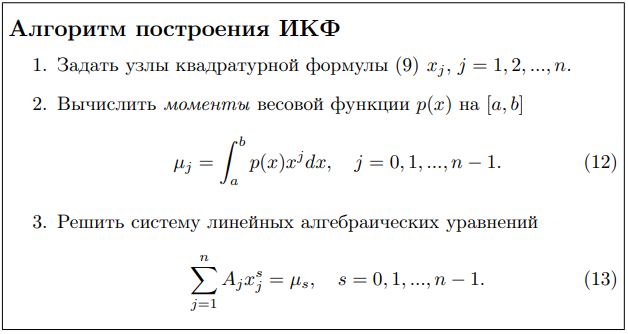

Для вычисления моментом, сделаем замену переменной $ t = x - a $ для того, чтобы упростить вычисление интеграла. Тогда моменты на промежутке $[\gamma_{1}, \gamma_{2}]$ будут вычислятся как:
$$ \mu_{k} = \int_{\gamma_{1}}^{\gamma_{2}} p(x)x^k \ dx \ = \int_{\gamma_{1} - a}^{\gamma_{2} - a} \frac{1}{t^\alpha}t^k \ dt \ = \frac{1}{k + 1 - \alpha}t^{k + 1 - \alpha} \bigg|_{\gamma_{1} - a}^{\gamma_{2} - a} $$

Для решения СЛАУ в пункте 3, мы воспользуемся матрицей Вандермонда. Если немного перевернуть ее, то мы сможем записать ее в виде: 
$$ 
X = \left(
\begin{array}{cccc}
1 & 1 & 1  & \ldots\\
x_{1} & x_{2} & x_{3}  & \ldots\\
x_{1}^2 & x_{2}^2 & x_{3}^2  & \ldots\\
\vdots & \vdots & \vdots & \ddots 
\end{array}
\right)
$$

Тогда мы сможем составить матричное уравнение для коэффицентов $ A_{j}: Xa=\mu $, где $a$ это вектор коэффицентов квадратурной формулы, а $\mu$ - вектор моментов. Решая СЛАУ, получим нужные нам коэффиценты, тогда само значение интеграла будет:
$$ \sum_{j=1}^{n} A_{j}f(x_{j}) $$

In [10]:
def moment(k, a, b):  # ищем моменты, с предварительной заменой переменной.
    Va = 1.1
    Vb = 2.3 # это верхняя гарница нашего интервала интегрирования. В общем случае она =b,
             # но для составных формул нужно задать ее отдельно
    # ans = ((Vb - a) ** (k + 1 - alpha) - (Vb - b) ** (k + 1 - alpha)) / (k + 1 - alpha)
    ans = ((b - Va) ** (k + 1 - alpha) - (a - Va) ** (k + 1 - alpha)) / (k + 1 - alpha)
    return ans


def IKF(f, a, b, n, return_coefs=False):
    Va = 1.1
    moments = []
    for i in range(n): # обратить внимание на коэффиценты в формулах (!!!)
        moments.append(moment(i, a, b))  # вычисляем моменты нашей функции
    xi = np.linspace(a, b, n)  # для последнего шага в алгоритме нам нужен будет обратный переход, поэтому оставим xi
    ti = xi - Va  # делаем замену переменной
    X = np.vander(ti, n, increasing=True).T  # Мы строим матрицу ti, например для ti=[1,2,3] она будет выглядеть так:
                                               # [[1, 1, 1], [1, 2, 3], [1, 4, 9]]. "повернутая" матрица Вандермонда
    A = np.linalg.solve(X, moments) # решаем систему, которая в методичке под номером (13)
    fs = f(xi) # точки, которые подставим в функцию
    if return_coefs:
        return sum(A*fs), A
    
    return sum(A*fs)

In [11]:
IKF(func, a, b, 3, True) # 27.56649553432024

(26.691038826460606, array([3.5356953 , 1.57142014, 0.07857101]))

Видим, что полученное значение довольно сильно отличается от того, что мы получили используя правило средних.

Исследуем, что будет с коэффицентами ИКФ, при повышении n. Т.к наши коэффиценты входят линейно в ИКФ, то мы можем посмотреть на их сумму модулей, от этого будет зависить оценка вычислительной погрешности.

In [12]:
N = 15
sAi = np.zeros(N)
ans_n = np.zeros(N)
for i in range(1, N+1):
    ans, ai = IKF(func, a, b, i, True)
    sAi[i-1] = np.linalg.norm(ai, ord=1) # это будет норма l1
    ans_n[i-1] = ans

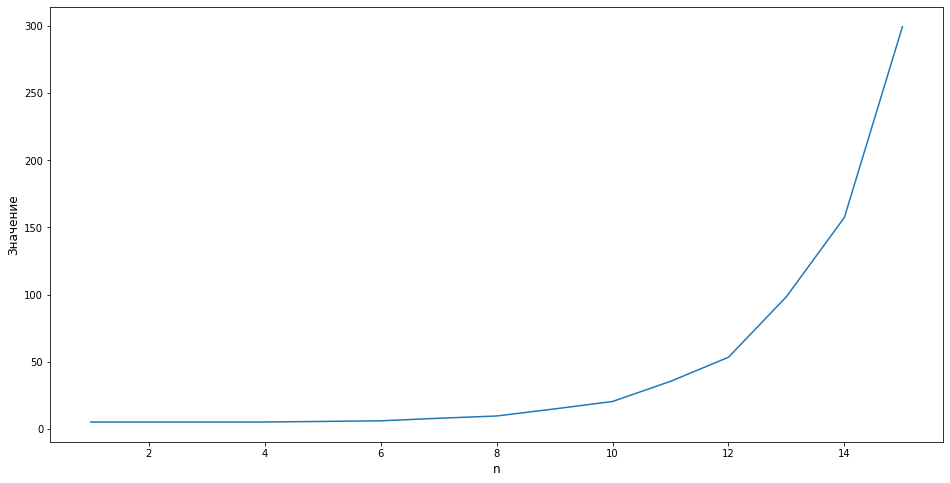

In [13]:
xi = np.arange(1, N+1, 1)

plt.figure(figsize=(16, 8))


plt.xlabel('n', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.plot(xi, sAi)


Как мы видим, уже начиная с 10, сумма модулей очень быстро растет, что может свидетельствовать о росте вычислительной погрешности. Это происходит из-за плохой обусловленности нашей матрицы Вандермонда.

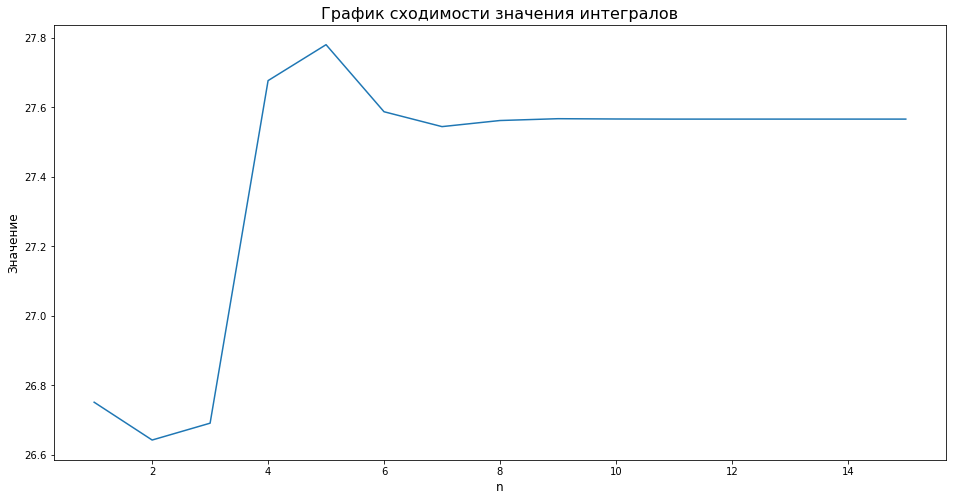

In [14]:
xi = np.arange(1, N+1, 1)

plt.figure(figsize=(16, 8))

plt.title('График сходимости значения интегралов', fontsize=16)

plt.xlabel('n', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.plot(xi, ans_n)

Наблюдаем довольно большой разброс значений нашего интеграла, хотя с n=8 он сходится к нужному значению. АСТ такого метода: $n-1$

**Доп.** В выше расмотренных случаях мы использовали ИКФ с равноотстоящими узлами. Такие формулы называют формулами Ньютона-Котса

## Алгоритм построения КФ типа Гаусса

Т.к. АСТ $n-1$ требует чтобы наша формула была интерполяционной, то мы не сможем повлиять на их вид так, чтобы увеличить АСТ. Тогда можно попробовать выбирать узлы $x_j$ особым образом. Из этой идеи возникает КФ Гаусса, ее АСТ равна $2n-1$. Т.е. выполняется:
$$ \mu_{s} = \int_{\gamma_{1}}^{\gamma_{2}} p(x)x^s \ dx \ = \sum_{j=1}^{n} A_{j}x_{j}^s,  \quad  s=0,1, ... , 2n-1$$

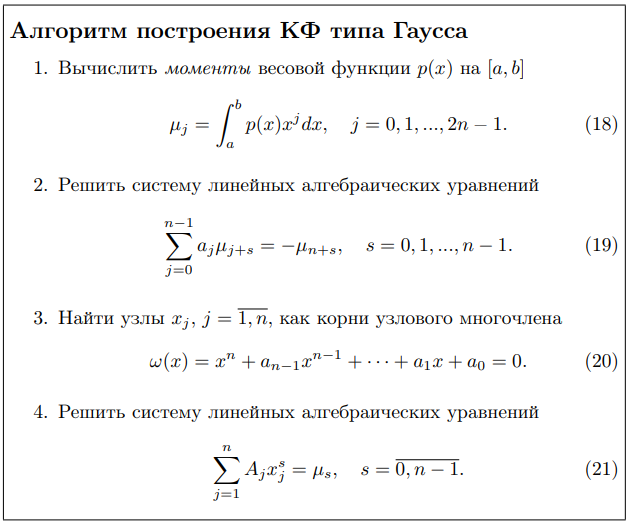

Решать СЛАУ мы будем как и в предыдущем случае, через матрицу вандермонда

In [15]:
def kf_gaus(f, a, b, n, return_coefs=False):
    Va = 1.1
    moments = []
    for i in range(2*n):
        moments.append(moment(i, a, b))  # находим моменты
    
    m1 = moments[:n]  # разбиваем моменты на две части, для удобства
    m2 = moments[n:]
    mu2 = [-el for el in m2]
    mm = np.zeros((n,n), dtype=float) # строим матрицу моментов, для того чтобы решить СЛАУ
    for i in range(n):
        mm[i, :] = moments[i:n+i]
    
    ai = np.linalg.solve(mm, mu2) # (19)
    ai = np.append(ai, 1)[::-1] # переворачиваем и добавляем 1 в начало, чтобы построить полином
    p = np.poly1d(ai) # строим полином
    xi = p.roots # находим корни полинома N. the algorithm relies on computing the eigenvalues of the companion matrix
        
    X = np.vander(xi, n, increasing=True).T # строим матрицу вандермонда
    A = np.linalg.solve(X, m1) # решаем СЛАУ (21)
    
    fs = func(xi+Va) # точки, которые подставим в функцию
    
    if return_coefs:
        return sum(A*fs), A
    
    return sum(A*fs)

In [16]:
kf_gaus(func, a, b, 2, True)

(27.31685337834087, array([0.93787096, 4.24781548]))

In [17]:
kf_gaus(func, a, b, 3, True)

(27.552295379679467, array([0.41270182, 1.09513243, 3.6778522 ]))

Обратим внимание на несколько интересных вещей. Например, то, что коэффиценты $Ai$ всегда больше нуля, и то, что их сумма всегда одинаковая. 

In [18]:
N = 15
sAi = np.zeros(N)
ans_n = np.zeros(N)
for i in range(1, N+1):
    ans, ai = kf_gaus(func, a, b, i, True)
    sAi[i-1] = np.linalg.norm(ai, ord=1) # это будет норма l1
    ans_n[i-1] = ans

In [19]:
sAi # сумма коэффицентов всегда одинакова.

array([5.18568645, 5.18568645, 5.18568645, 5.18568645, 5.18568645,
       5.18568645, 5.18568645, 5.18568645, 5.18568645, 5.18568645,
       5.18568645, 5.18568645, 5.18568645, 5.18568645, 5.18568645])

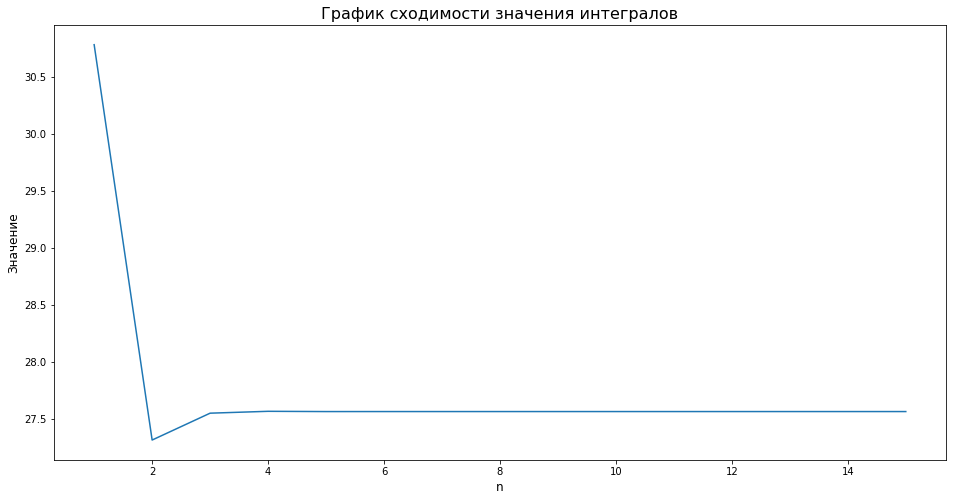

In [20]:
xi = np.arange(1, N+1, 1)

plt.figure(figsize=(16, 8))

plt.title('График сходимости значения интегралов', fontsize=16)

plt.xlabel('n', fontsize=12)
plt.ylabel('Значение', fontsize=12)

plt.plot(xi, ans_n)

Видим довольно быструю сходимость к определенному значению. Пока мы еще не говорили о точности наших вычислений.

## Составные квадратурные формулы

Основная идея составной квадратурной формулы состоит в том, чтобы разбить отрезок на промежутки, с целью повышения точности интегрирования. Так, уменьшив отрезок в $k$ раз, мы уменьшим погрешность вычислений в $k^{m-1}$ раз.

In [21]:
def comp_kf(f, a, b, h, n, kf=IKF): # по умолчанию мы используем ИКФ (Ньютона-Котеса)
    zi = np.arange(a, b+h, h) # разбиваем промежутки с заданным шагом
    ans = 0
    
    for i in range(len(zi)-1): # считаем нужной КФ на каждом промежутке
        ans += kf(f, zi[i], zi[i+1], n)
        
    return ans

In [22]:
comp_kf(func, a, b, 0.01, 3)

27.566496181190242

Посмотрим, на график сходимости нашего ответа в зависимости от n

In [23]:
N = 4
ans_ikf = np.zeros(N)
ans_gaus = np.zeros(N)
for i in range(1, N+1):
    ans_ikf[i-1] = comp_kf(func, a, b, 0.01, i)
    ans_gaus[i-1] = comp_kf(func, a, b, 0.01, i, kf_gaus)

Text(0, 0.5, 'Значение')

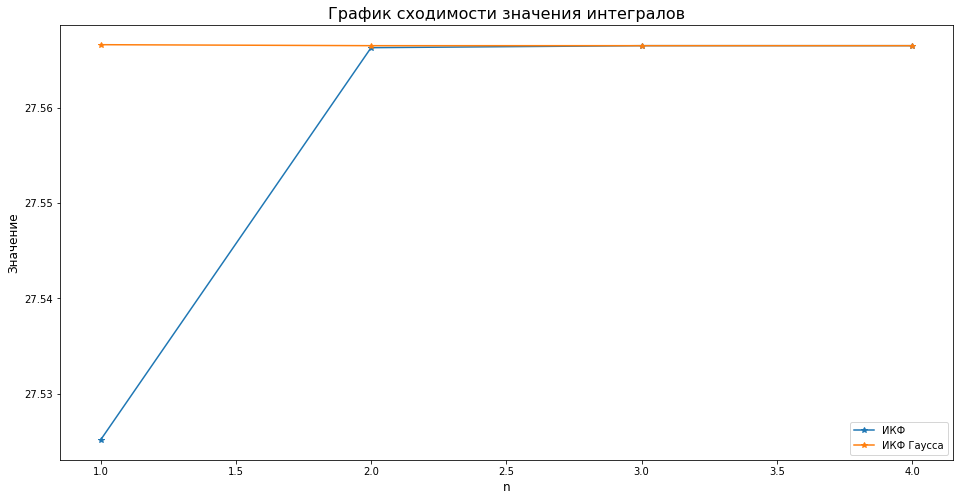

In [24]:
xi = np.arange(1, N+1, 1)

plt.figure(figsize=(16, 8))

plt.title('График сходимости значения интегралов', fontsize=16)

plt.plot(xi, ans_ikf, '*-', label='ИКФ')
plt.plot(xi, ans_gaus, '*-', label='ИКФ Гаусса')
plt.legend()

plt.xlabel('n', fontsize=12)
plt.ylabel('Значение', fontsize=12)

У формулы Гаусса удивительная сходимость. Интересно, так работает для всех функций или нет.

**Доп.** АСТ у составной квадратурной формулы зависит от соотношения и расположения малых формул по отрезкам, и оно может быть не целым

# Оценка погрешности 

До сих пор мы говорили только о АСТ и о скорости сходимости к ответу. Но то, куда сходились наши формулы, может быть далеко от истины, и иметь большую, относительно поставленной задачи, погрешность. В этом блоке мы рассмотрим как оценивать погрешность составной квадратурной формулы.

Используя формулу:
$$ R_N(f)=C_mh^m + O(h^{m+1}) $$
Где $C_m$ зависит только от нашей функции и ее формы. Мы будем рассматривать однородные КФ, в которой малые квадратурные формулы имеют АСТ m-1, а функция $f()$ имеет непрерывную производную вплоть до m

## Правило Рунге

Получается, что меняя $h$, мы можем воздействовать на нашу погрешность. Зададим связующий коэффицент $L>1$, и построим две сетки, с шагом $h_1=h, h_2 = h/L$. Тогда, посчитав значения интегралов $S_{h1}, S_{h2}$ мы сможем найти приближенные значения погрешностей $R_{h1}, R_{h2}$:
$$ R_{h1} \approx \frac{S_{h1} - S_{h2}}{1 - L^{-m}} \quad R_{h2} \approx \frac{S_{h1} - S_{h2}}{L^{m} - 1}$$

Используя это правило, мы можем решить вопрос выбора оптимального шага разбиения $h_{opt}$, которое будет обеспечивать необходимую точность $\varepsilon$:
$$ \varepsilon =  R_{h1}(\frac{h_{opt}}{h})^m \quad h_{opt} = h_1\sqrt[m]{\frac{\varepsilon}{|R_{h1}|}}$$

Вспомним, что $m$ зависит не только от АСТ малых КФ, но и от расположения малых КФ от отрезков. Т.к. мы пока не знаем, как находить $m$, мы будем предполагать, что наши малые квадратурные формулы имеют АСТ=m-1, следовательно можно сделать вывод, что для ИКФ будет иметь место зависимость: $m=n$, а для ИКФ Гаусса: $2m=n$

После того, как мы нашли оптимальный шаг, нам нужно домножить его на некий "гарантийный множитель", который меньше 1. Так же, нужно чтобы укладывалось целое количество шагов в наш интервав, поэтому мы округляем число $(b-a)/h_{opt}$ вверх, и делим на длину промежутка, находим окончательный оптимальный шаг

Так же, после того, как мы нашли оптимальный шаг, мы можем не попасть в область $C_m$, и не получить заданную точность вычислений. Тогда подставим $h_opt$, в качестве нового значения $h$ и прогоним метод еще раз.

In [25]:
def runge(f, a, b, m, eps, h=0.4, n=3, L=2, kf=IKF, fac=0.95, return_info=False): # m-АСТ; у ИКФ гаусса m=2n-1 + 1
    h1 = h # выбираем шаг
    h2 = h / L # делим на связующий множитель
    S1 = comp_kf(f, a, b, h1, n, kf) # считаем интегралы
    S2 = comp_kf(f, a, b, h2, n, kf)
    Rh1 = (S2 - S1) / (1 - L**(-m)) # считаем погрешности
    Rh2 = (S2 - S1) / (L**m - 1)
    h_opt = h1 * (eps / np.abs(Rh1))**(1/m) * fac # домножаем на гарантийный множитель
    h_opt = (b-a) / (np.ceil((b-a) / h_opt))  # для того, чтобы было целое число шагов
    print(h_opt)
    if (abs(Rh1) < eps) or (abs(Rh2) < eps): # or или and (???) // похоже, что or
        if return_info:
            print("Значение шага: {0}, L={1}".format(h_opt, L))
            print("Получились суммы:{0}, {1} c погрешностями:{2}, {3}".format(S1, S2, Rh1, Rh2))
            return h_opt, [S1, S2], [Rh1, Rh2]
        return h_opt 
    else:
        if return_info:
            return runge(func, a, b, m, eps, h_opt, return_info=True)
        return runge(func, a, b, m, eps, h_opt)

In [26]:
out = runge(func, a, b, 6, 1e-08, kf=kf_gaus, return_info=True)
print(out)

0.07499999999999998
0.0039735099337748336
0.0003436426116838487
0.0009958506224066388
Значение шага: 0.0009958506224066388, L=2
Получились суммы:27.56649553652052, 27.56649553650836 c погрешностями:-1.2353969699082276e-11, -1.9303077654816056e-13
(0.0009958506224066388, [27.56649553652052, 27.56649553650836], [-1.2353969699082276e-11, -1.9303077654816056e-13])


Мы запустили процесс для поиска оптимального разбиения для заданной точности $\varepsilon=10^{-8}$, а получили ответ с точностью, оцененной как $\varepsilon=10^{-13}$, что не может нас не радовать. Похоже у нас есть довольно хорошее эталонное значение ответа: 27.56649553650836

## Метод Ричардсона

Можно повысить точность нашей оценки, если использовать не 1 член, а $r$ членов в нашем асимптотическом разложении ряда:
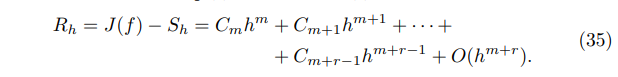
Тогда у нас $r+1$ неизвестная: $C_m, ... C_{m+r-1}, J(f)$  
Если провести $r+1$ рассчетов, по связанным сеткам, то сможем получить хорошее приближение.  
Тогда, у нас будет матричное уравнение $HC=S$, где:

$$ 
H = \left(
\begin{array}{cccc}
h_{1}^{m} & h_{1}^{m+1} & \ldots  & h_{1}^{m+r-1} & -1\\
h_{2}^{m} & h_{2}^{m+1} & \ldots  & h_{2}^{m+r-1} & -1\\
\vdots & \vdots & \ddots & \vdots \\
h_{r+1}^{m} & h_{r+1}^{m+1} & \ldots  & h_{r+1}^{m+r-1} & -1
\end{array}
\right)
\quad
C = \left(
\begin{array}{cccc}
C_m \\
C_{m+1} \\
\vdots  \\
C_{m+r-1} \\
J(f)
\end{array}
\right)
\quad
S = \left(
\begin{array}{cccc}
-S_{h_1}\\
-S_{h_2} \\
\vdots  \\
-S_{h_{r+1}}
\end{array}
\right)
$$

In [27]:
def rich(f, a, b, m, r, h=0.4, n=3, L=2, kf=IKF, fac=0.95, return_info=False):
    hi = np.ones(r + 1) # на самом деле, нам нужно только r hi, но последнее мы оставим =-1, как коэфф при J
    Si = np.ones(r + 1)
    for i in range(r + 1):
        hi[i] = h / (L)**i
        Si[i] = -comp_kf(f, a, b, hi[i], n, kf) # знак минус нужен нам, так как потом нужно использовать отрицат. вектор
    H = np.zeros((r + 1, r + 1))
    for i in range(r + 1): # построили матрицу из коэффицентов hi
        H[:, i] = hi ** (m + i)
    H[:, -1] = -1
    Ci_J = np.linalg.solve(H, Si) # получили вектор, где стоят Ci, а на последнем месте стоит J(f)
    Ci, Jf = Ci_J[:-1], Ci_J[-1] # разделили на вектор и J
    
    Rh = 0
    for i in range(len(Ci)):  # считаем Rh
        Rh += Ci[i] * h**(m+i)
    Sh = Jf - Rh  # Считаем сумму.
    
    return Sh, Jf, Rh # возвращает сумму с погрешностью, и приближение Jf

In [28]:
rich(func, a, b, 6, 3, h = 0.1, kf=kf_gaus)

(27.56649556706042, 27.566495536506945, -3.055347619351778e-08)

Метод возвращает нам значение суммы, приближение $J(f)$ и погрешность, с которой эта сумма вычислена

## Процесс Эйткена

Как мы уже было написано выше, мы не уверены, что наше $m$ всегда будет заданной изначально. Если такой уверенности нет, то мы можем ввести третью связанную сетку, поделив еще раз на $L$, и приближенно оценить значение нашего $m$, которое, в общем случае, может быть не целым:
$$ m \approx -\frac{ln\frac{S_{h3} - S_{h2}}{S_{h2} - S_{h1}}}{lnL}$$

In [29]:
def eitken(f, a, b, h=0.1, n=3, L=2, kf=IKF, fac=0.95):
    h1 = h
    h2 = h / L
    h3 = h2 / L
    S1 = comp_kf(f, a, b, h1, n, kf) 
    S2 = comp_kf(f, a, b, h2, n, kf)
    S3 = comp_kf(f, a, b, h3, n, kf)
    m = - np.log(np.abs((S3 - S2) / (S2 - S1))) / np.log(L)
    return m

In [30]:
eitken(func, a, b, kf=IKF)

3.060507276098521

In [31]:
eitken(func, a, b, kf=kf_gaus)

6.001181974872378

Как мы видим, наши значения $m$ примерно равны тому, что мы и ожидали, используя формулу $m=n$ для ИКФ, и $m=2n$ для ИКФ Гаусса

# Процесс Эйткена + Рунге

Мы можем совместить процессы Эйткена и Рунге. Построим три связанные сетки, найдем m, а дальше запустим процесс Рунге, уже с найденным M и разбиениеями $h_2$ и $h_3$. И будем повторять, если мы не войдем в область $C_m$, и нас не устроит приближение.
При вычислении $m$, по формуле выше, под логарифмом поставим модуль, для уменьшения погрешности

In [32]:
def eit_rung(f, a, b, eps, h=0.4, n=3, L=2, kf=IKF, fac=0.95, return_info=False):
    # идет процесс Эйткена
    h1 = h
    h2 = h / L
    h3 = h2 / L
    S1 = comp_kf(f, a, b, h1, n, kf) 
    S2 = comp_kf(f, a, b, h2, n, kf)
    S3 = comp_kf(f, a, b, h3, n, kf)
    m = - np.log(np.abs((S3 - S2) / (S2 - S1))) / np.log(L) # находим m
    
    # начинается процесс Рунге
    Rh2 = (S3 - S2) / (1 - L**(-m))
    Rh3 = (S3 - S2) / (L**m - 1)
    
    h_opt = h2 * (eps / np.abs(Rh2))**(1/m) * fac # домножаем на гарантийный множитель
    h_opt = (b-a) / (np.ceil((b-a) / h_opt))
    
    Cm = (S3 - S2)/(h**m * (1 - L**(-m)))

    if return_info:
        print('m:', m, 'h_opt:', h_opt, 'Rh2, Rh3:', Rh2, Rh3)
        print('S1, S2, S3', S1, S2, S3)
        print('--')

    if (abs(Rh2) < eps) or (abs(Rh3) < eps): 
        return h_opt, [S2, S3], [Rh2, Rh3] 
    else:
        return eit_rung(func, a, b, eps, h_opt, return_info=True)

In [33]:
eit_rung(func, a, b, 1e-10, n=2, kf=kf_gaus, return_info=True)

m: 4.16119877942871 h_opt: 0.004347826086956521 Rh2, Rh3: 0.0006628110057020329 3.704623357075644e-05
S1, S2, S3 27.55463553734941 27.565831379354698 27.56645714412683
--
m: 22.023140482739088 h_opt: 0.0017366136034732268 Rh2, Rh3: -4.43509866307512e-09 -1.0405846173232307e-15
S1, S2, S3 27.58539846894423 27.566495541485324 27.566495537050226
--


(0.0017366136034732268,
 [27.566495541485324, 27.566495537050226],
 [-4.43509866307512e-09, -1.0405846173232307e-15])

Непонятен такой бурный рост m, но метод, похоже, со своей задачей справился.

## Дополнительно

В процессе решение у нас было найдено решение, с отличной точностью: 27.566495537050226, точность до 15 знака. Это натолкнуло меня на мысль, взять это значение за эталонное, и посмотреть на скорость сходимсти ИКФ в зависимости от параметров, конкретно для моей функции.  
В общем случае, я понимаю, что нужно взять берущийся интеграл, проитнегрировать руками и получить эталонное значение, а потом уже смотреть на то как отрабатывают мои методы.

In [34]:
etalon = 27.566495537050226

In [35]:
N=20
xs = np.arange(1, N+1, 1)
IKFs = np.zeros(len(xs))
G_IKFs = np.zeros(len(xs))
SKFs = np.zeros(len(xs))
for i in xs:
    IKFs[i-1] = IKF(func, a, b, i)
    G_IKFs[i-1] = kf_gaus(func, a, b, i)
    SKFs[i-1] = comp_kf(func, a, b, 0.01, i)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning:

Casting complex values to real discards the imaginary part



In [36]:
y_I = [-np.log10(np.abs(x-etalon)) for x in IKFs]
y_G = [-np.log10(np.abs(x-etalon)) for x in G_IKFs]
y_S = [-np.log10(np.abs(x-etalon)) for x in SKFs]

Text(0, 0.5, '-log10(y-etalon)')

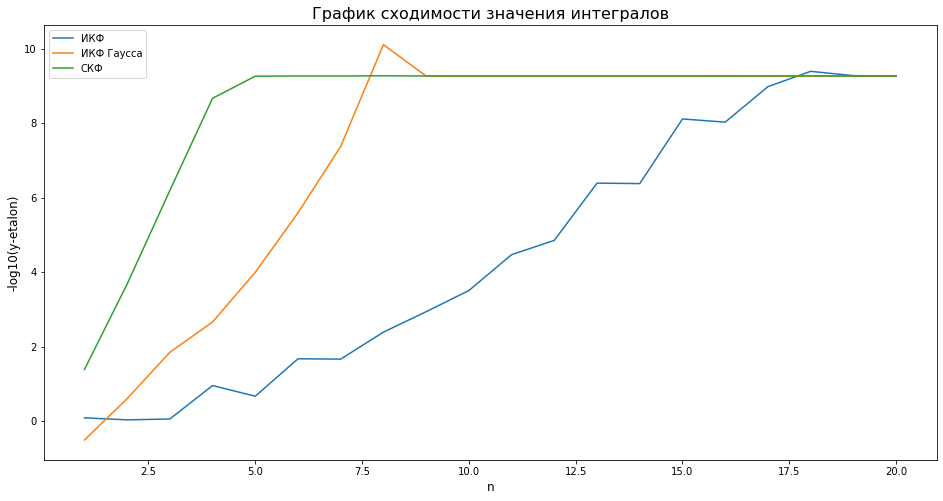

In [37]:

plt.figure(figsize=(16, 8))

plt.title('График сходимости значения интегралов', fontsize=16)

plt.plot(xs, y_I, label='ИКФ')
plt.plot(xs, y_G, label='ИКФ Гаусса')
plt.plot(xs, y_S, label='СКФ')
plt.legend()

plt.xlabel('n', fontsize=12)
plt.ylabel('-log10(y-etalon)', fontsize=12)

Интересно, что мы увеличиваем $n$, и по идее, в какой-то момент должна накапливаться погрешность. Но этого не происходит. Интеренсо почему.

In [38]:
# 27.566496235192854   -7
# 27.566495536506945   -8
# 27.566495613466447   -9 - 
# 27.56649553652052    -11
# 27.56649553650836    -13
# 27.566495536506807   -13, но не точно
# 27.566495537050226   -15
# 27.56649553432024     not my